In [ ]:
# Pytorch can be installed with the interactive selector:
# https://pytorch.org/get-started/locally/#windows-anaconda

# Note the GPU version requires cuda 12.1
# NOT cuda 12.3 (the latest version as of 2/1/24)
# Can be found here: https://developer.nvidia.com/cuda-12-1-0-download-archive

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import pandas as pd
# Here are some tools for gpu usage if you want to play with it:
# You can check if you have gpu setup and available here:
#print(torch.version.cuda)
#print(torch.cuda.is_available())

# However, in this case the gpu will likely be slower
# If you want to try it out uncomment this line, and then a few lines in the training section
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Load the dataset
# Load data, but skip the header
dataset = pd.read_csv('creditcard.csv', delimiter=',', dtype=np.float32)
dataset = dataset.to_numpy()

# get the number of data points and number of features
[num_datums, num_features] = dataset.shape

# The number of features is actually 1 less, because one of the columns is dedicated to the label
# num_features -= 1

# Shuffle the data in case somebody has it in an ordered list
np.random.shuffle(dataset)

In [7]:
# Now discretize for training, evaluating, validating
training_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

num_train = round(num_datums * training_ratio)
num_valid = round(num_datums * validation_ratio)
num_test = round(num_datums * test_ratio)

# Create all of the split datasets as numpy arrays
X_training_np = dataset[0:num_train, 0:num_features]
y_training_np = dataset[0:num_train, -1]

X_validation_np = dataset[num_train:num_train+num_valid, 0:num_features]
y_validation_np = dataset[num_train:num_train+num_valid, -1]

X_test_np = dataset[num_train+num_valid:, 0:num_features]
y_test_np = dataset[num_train+num_valid:, -1]

In [8]:
# Convert the numpy arrays into torch tensors (pretty much the same thing)
X_training = torch.from_numpy(X_training_np)
y_training = torch.from_numpy(y_training_np).reshape(-1,1)

In [6]:
# Create our network
# neural_network = torch.nn.Sequential(
#     torch.nn.Linear(num_features,12),
#     torch.nn.ReLU(),
#     torch.nn.Linear(12,8),
#     torch.nn.ReLU(),
#     torch.nn.Linear(8,1),
#     torch.nn.Sigmoid()
# )

# Another approach that is easy to modify number of hidden_layers:
#num_hidden_layers = 4
#num_hidden_nodes = 12
#
#initial_layer = torch.nn.Linear(num_features, num_hidden_nodes)
#layer_list = [initial_layer]
#
#for i in range(num_hidden_layers-1):
#    layer_list.append( torch.nn.ReLU() )
#    layer_list.append( torch.nn.Linear(num_hidden_nodes,num_hidden_nodes))
#
#layer_list.append( torch.nn.ReLU() )
#layer_list.append( torch.nn.Linear(num_hidden_nodes, 1))
#layer_list.append( torch.nn.Sigmoid() )
#
#neural_network = torch.nn.Sequential(*layer_list)

In [13]:
# Define other parameters of the network
loss_function = torch.nn.BCELoss() # Binary cross entropy
# optimizer = torch.optim.Adam(neural_network.parameters())

In [ ]:
# If you want to try using the gpu then uncomment here:
# Send our tensors to the gpu if it is available
#X_training = X_training.to(device)
#y_training = y_training.to(device)

# Send the model to the gpu
#neural_network.to(device)

In [14]:
# Train your model

# NOTE: Something cool about pytorch is that it is dynamically updating the model, so
# if you interrupt the script it saves the models current state and you can move on to
# validating

# num_epochs = 20
# batch_size = 1000
# num_batches = round(num_train/batch_size)
def train_model(num_epochs, batch_size, num_batches):
    for epoch in range(num_epochs):
        t = time.time() # Measure the time of the epoch
        for batch in range(num_batches):
            # Get a batch of the training data
            X_batch = X_training[batch*batch_size:(batch+1)*batch_size]
            y_batch = y_training[batch*batch_size:(batch+1)*batch_size]

            # Deploy the model
            y_prediction = neural_network(X_batch)

            # Compute loss
            loss = loss_function(y_prediction, y_batch)

            # Back propogation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Compute the time of the epoch
        elapsed_time = time.time() - t

        # Print results of epoch
        print(f'Epoch {epoch+1}/{num_epochs} completed in {elapsed_time:.2f}s, loss {loss:.10f}')
        

# train_model(20, 1000, round(num_train/1000))

In [15]:
# Evaluate model
# Convert the data to tensors
X_validation = torch.from_numpy(X_validation_np)
y_valdation = torch.from_numpy(y_validation_np).reshape(-1,1)

# Run the model
y_prediction = neural_network(X_validation)
# Round the results
y_prediction = y_prediction.round()

# See how many are different
num_matches = sum(y_prediction==y_valdation)

# Compute accuracy
accuracy = float(num_matches/num_valid)


print(f"Accuracy {accuracy:.5f}")

Accuracy 0.99849


In [16]:
def validation_function(): 
    total_loss = 0
    total_samples = 0
    
    # Set the model to evaluation mode
    neural_network.eval()

    # Loop over your validation data
    with torch.no_grad(): 
        # Convert numpy arrays to PyTorch tensors
        X_validation = torch.from_numpy(X_validation_np).float()
        y_validation = torch.from_numpy(y_validation_np).reshape(-1,1).float()
        
        # Make predictions 
        y_prediction = neural_network(X_validation)

        # Compute loss
        loss = loss_function(y_prediction, y_validation)

        total_loss += loss.item() * X_validation.size(0)
        total_samples += X_validation.size(0)

    # Calculate average loss
    avg_loss = total_loss / total_samples

    # switch back to train mode
    neural_network.train()

    return avg_loss


In [17]:
# Define the epochs to search
epochs_list = [10, 20, 50, 100]

best_val_loss = float('inf') # tracking best validation loss
best_epochs = epochs_list[0]

batch_size = 64
num_batches = round(len(X_training) / batch_size)

lr = 0.001
grid_losses = []
grid_epochs = []
for num_epochs in epochs_list:
    neural_network = torch.nn.Sequential(
        torch.nn.Linear(num_features,12),
        torch.nn.ReLU(),
        torch.nn.Linear(12,8),
        torch.nn.ReLU(),
        torch.nn.Linear(8,1),
        torch.nn.Sigmoid()
    )

    
    # Instantiate a new model for each number of epochs
    optimizer = torch.optim.Adam(neural_network.parameters(), lr=lr)
    
    train_model(num_epochs, batch_size, num_batches)
    val_loss = validation_function()
    
    print(f"Number of epochs: {num_epochs}, Validation loss: {val_loss:.4f}")
    
    # check if this number of epochs gives a better validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epochs = num_epochs
    grid_losses.append(val_loss)
    grid_epochs.append(num_epochs)
print(f"Best number of epochs by grid search: {best_epochs}, validation loss: {best_val_loss:10f}")


Epoch 1/10 completed in 2.52s, loss 0.0000000000
Epoch 2/10 completed in 2.56s, loss 0.0000000000
Epoch 3/10 completed in 2.45s, loss 0.0000000000
Epoch 4/10 completed in 2.40s, loss 0.0000000000
Epoch 5/10 completed in 2.38s, loss 0.0000000000
Epoch 6/10 completed in 2.57s, loss 0.0000000000
Epoch 7/10 completed in 2.48s, loss 0.0000000000
Epoch 8/10 completed in 2.48s, loss 0.0000000000
Epoch 9/10 completed in 2.49s, loss 0.0000000000
Epoch 10/10 completed in 2.49s, loss 0.0000000000
Number of epochs: 10, Validation loss: 0.1510
Epoch 1/20 completed in 2.47s, loss 0.0000000000
Epoch 2/20 completed in 2.51s, loss 0.0000000000
Epoch 3/20 completed in 2.43s, loss 0.0000000000
Epoch 4/20 completed in 2.49s, loss 0.0000000000
Epoch 5/20 completed in 2.43s, loss 0.0000000000
Epoch 6/20 completed in 2.45s, loss 0.0000000000
Epoch 7/20 completed in 2.49s, loss 0.0000000000
Epoch 8/20 completed in 2.46s, loss 0.0000000000
Epoch 9/20 completed in 2.47s, loss 0.0000000000
Epoch 10/20 completed 

In [18]:
print(grid_epochs)

[10, 20, 50, 100]


In [20]:
import optuna
def objective(trial):
    
    # Suggest a number of epochs
    num_epochs = trial.suggest_int("num_epochs", 50, 200)

    # Instantiate a new model for each number of epochs
    neural_network = torch.nn.Sequential(
        torch.nn.Linear(num_features,12),
        torch.nn.ReLU(),
        torch.nn.Linear(12,8),
        torch.nn.ReLU(),
        torch.nn.Linear(8,1),
        torch.nn.Sigmoid()
    )

    optimizer = torch.optim.Adam(neural_network.parameters(), lr=0.001)

    train_model(num_epochs, batch_size, num_batches)
    val_loss = validation_function() 
    return val_loss  # aim is to find the hyperparameters that minimize this value

# Create a study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)
bayes_losses = [trial.value for trial in study.trials]
bayes_epochs = [trial.params["num_epochs"] for trial in study.trials]

# best hyperparameters
best_hyperparameters = study.best_params
print(f"Best hyperparameters: {best_hyperparameters}")


/Users/joel-carlson/miniconda3/envs/ML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-03-04 18:30:04,609] A new study created in memory with name: no-name-24968d3c-048c-4228-84b8-bcf59febe330


Epoch 1/150 completed in 2.41s, loss 0.0000000000
Epoch 2/150 completed in 2.38s, loss 0.0000000000
Epoch 3/150 completed in 2.45s, loss 0.0000000000
Epoch 4/150 completed in 2.48s, loss 0.0000000000
Epoch 5/150 completed in 2.43s, loss 0.0000000000
Epoch 6/150 completed in 2.50s, loss 0.0000000000
Epoch 7/150 completed in 2.50s, loss 0.0000000000
Epoch 8/150 completed in 2.47s, loss 0.0000000000
Epoch 9/150 completed in 2.32s, loss 0.0000000000
Epoch 10/150 completed in 2.36s, loss 0.0000000000
Epoch 11/150 completed in 2.59s, loss 0.0000000000
Epoch 12/150 completed in 2.64s, loss 0.0000000000
Epoch 13/150 completed in 2.51s, loss 0.0000000000
Epoch 14/150 completed in 2.38s, loss 0.0000000000
Epoch 15/150 completed in 2.48s, loss 0.0000000000
Epoch 16/150 completed in 2.49s, loss 0.0000000000
Epoch 17/150 completed in 2.50s, loss 0.0000000000
Epoch 18/150 completed in 2.40s, loss 0.0000000000
Epoch 19/150 completed in 2.49s, loss 0.0000000000
Epoch 20/150 completed in 2.44s, loss 0.

[I 2024-03-04 18:36:23,386] Trial 0 finished with value: 0.15098050236701965 and parameters: {'num_epochs': 150}. Best is trial 0 with value: 0.15098050236701965.


Epoch 150/150 completed in 2.62s, loss 0.0000000000
Epoch 1/78 completed in 2.60s, loss 0.0000000000
Epoch 2/78 completed in 2.57s, loss 0.0000000000
Epoch 3/78 completed in 2.61s, loss 0.0000000000
Epoch 4/78 completed in 2.55s, loss 0.0000000000
Epoch 5/78 completed in 2.52s, loss 0.0000000000
Epoch 6/78 completed in 2.46s, loss 0.0000000000
Epoch 7/78 completed in 2.47s, loss 0.0000000000
Epoch 8/78 completed in 2.44s, loss 0.0000000000
Epoch 9/78 completed in 2.42s, loss 0.0000000000
Epoch 10/78 completed in 2.45s, loss 0.0000000000
Epoch 11/78 completed in 2.42s, loss 0.0000000000
Epoch 12/78 completed in 2.45s, loss 0.0000000000
Epoch 13/78 completed in 2.42s, loss 0.0000000000
Epoch 14/78 completed in 2.44s, loss 0.0000000000
Epoch 15/78 completed in 2.42s, loss 0.0000000000
Epoch 16/78 completed in 2.48s, loss 0.0000000000
Epoch 17/78 completed in 2.46s, loss 0.0000000000
Epoch 18/78 completed in 2.55s, loss 0.0000000000
Epoch 19/78 completed in 2.59s, loss 0.0000000000
Epoch 2

[I 2024-03-04 18:39:49,884] Trial 1 finished with value: 0.15098050236701965 and parameters: {'num_epochs': 78}. Best is trial 0 with value: 0.15098050236701965.


Epoch 78/78 completed in 3.11s, loss 0.0000000000
Epoch 1/116 completed in 2.96s, loss 0.0000000000
Epoch 2/116 completed in 2.98s, loss 0.0000000000
Epoch 3/116 completed in 2.88s, loss 0.0000000000
Epoch 4/116 completed in 2.86s, loss 0.0000000000
Epoch 5/116 completed in 2.94s, loss 0.0000000000
Epoch 6/116 completed in 2.95s, loss 0.0000000000
Epoch 7/116 completed in 2.92s, loss 0.0000000000
Epoch 8/116 completed in 2.86s, loss 0.0000000000
Epoch 9/116 completed in 2.83s, loss 0.0000000000
Epoch 10/116 completed in 2.87s, loss 0.0000000000
Epoch 11/116 completed in 3.16s, loss 0.0000000000
Epoch 12/116 completed in 3.57s, loss 0.0000000000
Epoch 13/116 completed in 3.13s, loss 0.0000000000
Epoch 14/116 completed in 3.33s, loss 0.0000000000
Epoch 15/116 completed in 3.07s, loss 0.0000000000
Epoch 16/116 completed in 3.65s, loss 0.0000000000
Epoch 17/116 completed in 4.68s, loss 0.0000000000
Epoch 18/116 completed in 4.27s, loss 0.0000000000
Epoch 19/116 completed in 3.61s, loss 0.0

[I 2024-03-04 18:45:53,551] Trial 2 finished with value: 0.15098050236701965 and parameters: {'num_epochs': 116}. Best is trial 0 with value: 0.15098050236701965.


Epoch 116/116 completed in 3.12s, loss 0.0000000000
Epoch 1/63 completed in 3.23s, loss 0.0000000000
Epoch 2/63 completed in 3.09s, loss 0.0000000000
Epoch 3/63 completed in 3.04s, loss 0.0000000000
Epoch 4/63 completed in 2.99s, loss 0.0000000000
Epoch 5/63 completed in 3.12s, loss 0.0000000000
Epoch 6/63 completed in 3.12s, loss 0.0000000000
Epoch 7/63 completed in 3.29s, loss 0.0000000000
Epoch 8/63 completed in 3.11s, loss 0.0000000000
Epoch 9/63 completed in 3.14s, loss 0.0000000000
Epoch 10/63 completed in 3.46s, loss 0.0000000000
Epoch 11/63 completed in 3.14s, loss 0.0000000000
Epoch 12/63 completed in 3.48s, loss 0.0000000000
Epoch 13/63 completed in 3.28s, loss 0.0000000000
Epoch 14/63 completed in 3.30s, loss 0.0000000000
Epoch 15/63 completed in 3.29s, loss 0.0000000000
Epoch 16/63 completed in 3.47s, loss 0.0000000000
Epoch 17/63 completed in 3.21s, loss 0.0000000000
Epoch 18/63 completed in 3.24s, loss 0.0000000000
Epoch 19/63 completed in 3.43s, loss 0.0000000000
Epoch 2

[I 2024-03-04 18:49:11,279] Trial 3 finished with value: 0.15098050236701965 and parameters: {'num_epochs': 63}. Best is trial 0 with value: 0.15098050236701965.


Epoch 63/63 completed in 3.06s, loss 0.0000000000
Epoch 1/96 completed in 3.10s, loss 0.0000000000
Epoch 2/96 completed in 3.21s, loss 0.0000000000
Epoch 3/96 completed in 3.12s, loss 0.0000000000
Epoch 4/96 completed in 2.87s, loss 0.0000000000
Epoch 5/96 completed in 2.95s, loss 0.0000000000
Epoch 6/96 completed in 3.14s, loss 0.0000000000
Epoch 7/96 completed in 3.43s, loss 0.0000000000
Epoch 8/96 completed in 3.31s, loss 0.0000000000
Epoch 9/96 completed in 3.20s, loss 0.0000000000
Epoch 10/96 completed in 3.17s, loss 0.0000000000
Epoch 11/96 completed in 3.22s, loss 0.0000000000
Epoch 12/96 completed in 3.03s, loss 0.0000000000
Epoch 13/96 completed in 2.94s, loss 0.0000000000
Epoch 14/96 completed in 2.86s, loss 0.0000000000
Epoch 15/96 completed in 3.00s, loss 0.0000000000
Epoch 16/96 completed in 2.82s, loss 0.0000000000
Epoch 17/96 completed in 2.80s, loss 0.0000000000
Epoch 18/96 completed in 2.75s, loss 0.0000000000
Epoch 19/96 completed in 2.71s, loss 0.0000000000
Epoch 20/

[I 2024-03-04 18:55:18,872] Trial 4 finished with value: 0.15098050236701965 and parameters: {'num_epochs': 96}. Best is trial 0 with value: 0.15098050236701965.


Epoch 96/96 completed in 2.47s, loss 0.0000000000
Best hyperparameters: {'num_epochs': 150}


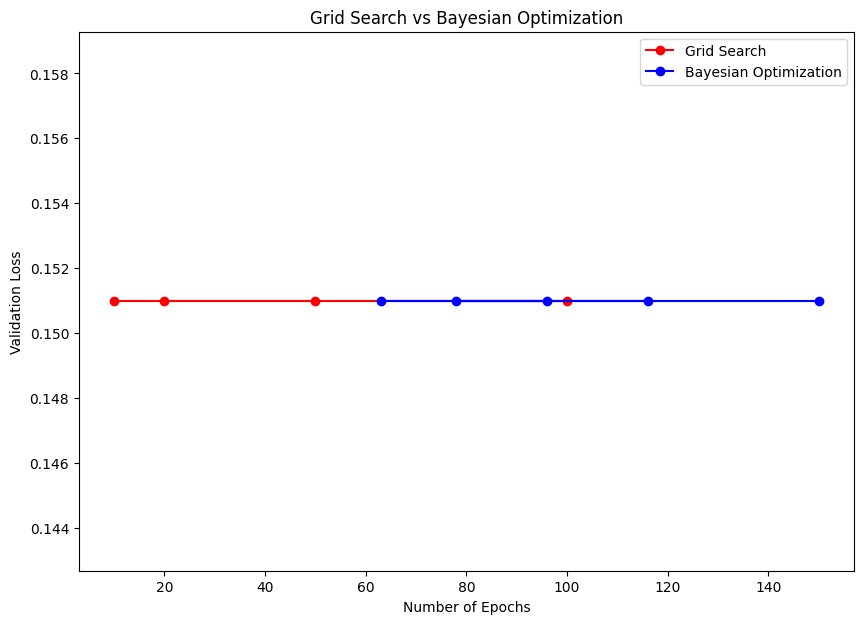

In [21]:
plt.figure(figsize=(10,7))

# Plot grid search results
plt.plot(grid_epochs, grid_losses, marker='o', linestyle='-', color='r', label='Grid Search')

# Plot bayesian optimization results
plt.plot(bayes_epochs, bayes_losses, marker='o', linestyle='-', color='b', label='Bayesian Optimization')

plt.xlabel('Number of Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Grid Search vs Bayesian Optimization')
plt.show()

In [ ]:
# DON'T TOUCH THIS UNTIL YOU ARE DONE TUNING YOUR HYPERPARAMETERS
# Convert the data to tensors
#X_test = torch.from_numpy(X_test_np)
#y_test = torch.from_numpy(y_test_np).reshape(-1,1)

# Run the model
#y_prediction = neural_network(X_test)
# Round the results
#y_prediction = y_prediction.round()

# See how many are different
#num_matches = sum(y_prediction==y_test)

# Compute accuracy
#accuracy = float(num_matches/num_test)

#print(f"Final Accuracy {accuracy:.5f}")